In [1]:
# Install via terminal in ubuntu
# sudo apt install pip
# pip install scikit-learn pandas seaborn tensorflow scikeras
# !pip install keras-tuner --upgrade

In [2]:
# sc master - running locally
sc.master

'local[*]'

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

2023-10-08 17:38:13.880129: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-08 17:38:14.008393: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-08 17:38:14.008418: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-08 17:38:14.008443: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-08 17:38:14.114372: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-08 17:38:14.115044: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Data reading and final cleaning

In [5]:
# Read the cleaned dataset from hadoop. 
# This has been renamed from part-00000-cdda873a-60d8-4ecc-b275-06323eb00068-c000.csv to cleaned_TMBD_dataset
dataPath = "/CA1/data/cleaned/cleaned_TMDB_dataset.csv"
cleanedDF = spark.read \
    .option("multiline", "true") \
    .option("quote", '"') \
    .option("header", "true") \
    .option("escape", "\\") \
    .option("escape", '"') \
    .csv(dataPath, header = True, inferSchema = True)
cleanedDF.toPandas().head()

2023-10-08 17:38:20,588 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,title,vote_average,status,runtime,popularity,release_year,genre_count,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,Inception,8.364,Released,148,83.952,2010,3,1.0,1,0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,Interstellar,8.417,Released,169,140.241,2014,3,0.0,1,0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,The Dark Knight,8.512,Released,152,130.643,2008,4,1.0,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,Avatar,7.573,Released,162,79.932,2009,4,1.0,1,0,0.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,The Avengers,7.71,Released,143,98.082,2012,3,1.0,1,0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [6]:
cleanedDF.printSchema()

root
 |-- title: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- status: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- release_year: string (nullable = true)
 |-- genre_count: string (nullable = true)
 |-- Action: double (nullable = true)
 |-- Adventure: string (nullable = true)
 |-- Animation: integer (nullable = true)
 |-- Comedy: double (nullable = true)
 |-- Crime: integer (nullable = true)
 |-- Documentary: integer (nullable = true)
 |-- Drama: integer (nullable = true)
 |-- Family: integer (nullable = true)
 |-- Fantasy: integer (nullable = true)
 |-- History: integer (nullable = true)
 |-- Horror: integer (nullable = true)
 |-- Music: integer (nullable = true)
 |-- Mystery: integer (nullable = true)
 |-- Romance: integer (nullable = true)
 |-- Science Fiction: integer (nullable = true)
 |-- TV Movie: integer (nullable = true)
 |-- Thriller: integer (nullable = true)
 |-- War: integer (null

Since there are incorrectly typed columns in the schema, it must be set to the correct type first to prevent issues in the training. String columns will now be removed so only numerical columns are left.

In [7]:
cleanedDF = cleanedDF.withColumn("runtime", cleanedDF["runtime"].cast("int"))
cleanedDF = cleanedDF.withColumn("popularity", cleanedDF["popularity"].cast("float"))
cleanedDF = cleanedDF.withColumn("release_year", cleanedDF["release_year"].cast("int"))
cleanedDF = cleanedDF.withColumn("Action", cleanedDF["Action"].cast("int"))
cleanedDF = cleanedDF.withColumn("Adventure", cleanedDF["Adventure"].cast("int"))
cleanedDF = cleanedDF.withColumn("Animation", cleanedDF["Animation"].cast("int"))
cleanedDF = cleanedDF.withColumn("Crime", cleanedDF["Crime"].cast("int"))
cleanedDF = cleanedDF.withColumn("vote_average", cleanedDF["vote_average"].cast("float"))
cleanedDF = cleanedDF.withColumn("genre_count", cleanedDF["genre_count"].cast("int"))
cleanedDF = cleanedDF.withColumn("comedy", cleanedDF["comedy"].cast("int"))


cleanedDF = cleanedDF.drop("title")
cleanedDF = cleanedDF.drop("status")
# cleanedDF = cleanedDF.drop("release_year")
# cleanedDF = cleanedDF.drop("popularity")
cleanedDF.printSchema()

root
 |-- vote_average: float (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- popularity: float (nullable = true)
 |-- release_year: integer (nullable = true)
 |-- genre_count: integer (nullable = true)
 |-- Action: integer (nullable = true)
 |-- Adventure: integer (nullable = true)
 |-- Animation: integer (nullable = true)
 |-- comedy: integer (nullable = true)
 |-- Crime: integer (nullable = true)
 |-- Documentary: integer (nullable = true)
 |-- Drama: integer (nullable = true)
 |-- Family: integer (nullable = true)
 |-- Fantasy: integer (nullable = true)
 |-- History: integer (nullable = true)
 |-- Horror: integer (nullable = true)
 |-- Music: integer (nullable = true)
 |-- Mystery: integer (nullable = true)
 |-- Romance: integer (nullable = true)
 |-- Science Fiction: integer (nullable = true)
 |-- TV Movie: integer (nullable = true)
 |-- Thriller: integer (nullable = true)
 |-- War: integer (nullable = true)
 |-- Western: integer (nullable = true)



In [8]:
cleanedDF.toPandas().head()

,vote_average,runtime,popularity,release_year,genre_count,Action,Adventure,Animation,comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,8.364,148.0,83.952003,2010.0,3.0,1,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,8.417,169.0,140.240997,2014.0,3.0,0,1.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,8.512,152.0,130.643005,2008.0,4.0,1,0.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,7.573,162.0,79.931999,2009.0,4.0,1,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,7.710,143.0,98.082001,2012.0,3.0,1,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [9]:
cleanedPandasDF = cleanedDF.toPandas()
# X = cleanedDF.columns[0]
# independentColumns = cleanedDF.columns[1:]

In [10]:
cleanedPandasDF = cleanedPandasDF.dropna()

In [11]:
cleanedPandasDF.shape

(477722, 24)

In [12]:
cleanedPandasDF["Adventure"] = cleanedPandasDF["Adventure"].astype(float)
X = cleanedPandasDF.drop(columns=[cleanedDF.columns[0]])
y = cleanedPandasDF[cleanedDF.columns[0]]
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Scaling the data
In the EDA, the data contains outliers hence it's not applicable to use standard scaler. Robust scaler was used instead since it can handle outlier very well.

In [13]:
scaler = RobustScaler()
# scaler = StandardScaler()
XTrainScaled = scaler.fit_transform(XTrain)
XTestScaled = scaler.transform(XTest)

### Converting to Tensorflow Dataset
Convert the pandas dataframe to tensor dataset so that it can be used by tensforflow operations and for efficiency purposes as well (i.e. data processing and parallelism).

In [14]:
# trainDataset = tf.data.Dataset.from_tensor_slices((XTrainScaled, yTrain))
# testDataset = tf.data.Dataset.from_tensor_slices((XTestScaled, yTest))

2023-10-08 17:38:34.611582: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 70320568 exceeds 10% of free system memory.


In [16]:
# model.fit(XTrainScaled, yTrain, epochs=100, batch_size=100, validation_split=0.2)

### Function for creating model
It has 4 layers with 2 hidden layers since the problem is not complex. The hidden layers have 4-7 neurons (depending on the hyperparameters) which is based on the rule where each hidden layer should have a sqrt(input * output).

Due to data being sparse because of one-hot encoding, Adadelta was used (which is more efficient than Adagrad). For the loss function, mean absolute error was used due to presence of outliers.

In [88]:
def createModel(
    activation = "relu", 
    learningRate = 0.1, 
    loss = "mean_squared_logarithmic_error"
): 
    model = keras.Sequential()
    model.add(keras.layers.Input(shape = (XTrainScaled.shape[1],)))
    model.add(keras.layers.Dense(
        units = 512, 
        kernel_initializer='normal', 
        use_bias = True,
        activation=activation))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(
        units = 512, 
        kernel_initializer='normal', 
        use_bias = True,
        activation=activation))
    model.add(keras.layers.Dropout(0.2))
#     model.add(keras.layers.Dense(
#         hiddenUnits, 
#         kernel_initializer='normal', 
#         activation="relu"))
    model.add(keras.layers.Dense(
        1
        ))
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate = learningRate),
        loss=loss, 
        metrics=['accuracy']
    )
        
    return model

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)
    
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy [MPG]')
    plt.legend()
    plt.grid(True)

In [89]:
initialModel = createModel()

In [90]:
history = initialModel.fit(
    XTrainScaled,
    yTrain,
    validation_split = 0.2,
    verbose = 1, epochs = 10,
    batch_size = 50,
)

Epoch 1/10
6115/6115 [==============================] - 19s 3ms/step - loss: 1.9846 - accuracy: 0.4655 - val_loss: 1.9852 - val_accuracy: 0.4655
Epoch 2/10
6115/6115 [==============================] - 20s 3ms/step - loss: 1.9830 - accuracy: 0.4656 - val_loss: 1.9852 - val_accuracy: 0.4655
Epoch 3/10
6115/6115 [==============================] - 18s 3ms/step - loss: 1.9830 - accuracy: 0.4656 - val_loss: 1.9852 - val_accuracy: 0.4655
Epoch 4/10
6115/6115 [==============================] - 19s 3ms/step - loss: 1.9830 - accuracy: 0.4656 - val_loss: 1.9852 - val_accuracy: 0.4655
Epoch 5/10
6115/6115 [==============================] - 18s 3ms/step - loss: 1.9830 - accuracy: 0.4656 - val_loss: 1.9852 - val_accuracy: 0.4655
Epoch 6/10
6115/6115 [==============================] - 18s 3ms/step - loss: 1.9830 - accuracy: 0.4656 - val_loss: 1.9852 - val_accuracy: 0.4655
Epoch 7/10
6115/6115 [==============================] - 18s 3ms/step - loss: 1.9830 - accuracy: 0.4656 - val_loss: 1.9852 - val_ac

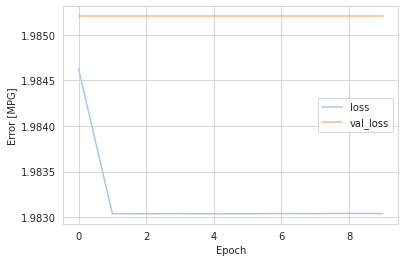

In [91]:
plot_loss(history)

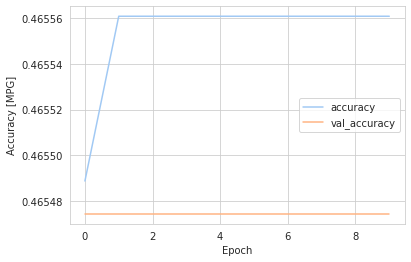

In [92]:
plot_accuracy(history)

In [93]:
initialYPred = initialModel.predict(XTest)

2986/2986 [==============================] - 3s 884us/step


In [108]:
from sklearn.metrics import log_loss, mean_squared_error, mean_absolute_error
# Calculate loss for regression
InitialMSEloss = mean_squared_error(yTest, initialYPred)
InitialRMSEloss = mean_squared_error(yTest, initialYPred, squared=False)
InitialMAE = mean_absolute_error(yTest, initialYPred)

print(InitialMSEloss, InitialRMSEloss, InitialMAE)

75147610000000.0 8668772.0 8666200.0


### Hyperparameter Tuning

In [18]:
parameters = dict(
    model__activation = ["relu", "sigmoid"],
    batch_size = np.array([10, 50, 100]),
    epochs = np.array([10, 20]),
    model__learningRate = np.array([0.1, 0.01, 1]),
    model__loss = ["mean_squared_logarithmic_error", "mean_squared_error", "mean_absolute_error"]
)

In [19]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
model = KerasRegressor(build_fn=createModel,verbose=1)

bestModel = RandomizedSearchCV(estimator = model,
                               param_distributions = parameters,
                               verbose = 1,
                               cv = 3
                              )

In [20]:
bestModel.fit(XTrainScaled, yTrain)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/20
5096/5096 [==============================] - 14s 3ms/step - loss: 2.0688 - accuracy: 0.4645
Epoch 2/20
5096/5096 [==============================] - 13s 3ms/step - loss: 1.9813 - accuracy: 0.4661
Epoch 3/20
5096/5096 [==============================] - 13s 3ms/step - loss: 1.9813 - accuracy: 0.4661
Epoch 4/20
5096/5096 [==============================] - 13s 3ms/step - loss: 1.9813 - accuracy: 0.4661
Epoch 5/20
5096/5096 [==============================] - 14s 3ms/step - loss: 1.9813 - accuracy: 0.4661
Epoch 6/20
5096/5096 [==============================] - 14s 3ms/step - loss: 1.9813 - accuracy: 0.4661
Epoch 7/20
5096/5096 [==============================] - 14s 3ms/step - loss: 1.9813 - accuracy: 0.4661
Epoch 8/20
5096/5096 [==============================] - 14s 3ms/step - loss: 1.9813 - accuracy: 0.4661
Epoch 9/20
5096/5096 [==============================] - 14s 3ms/step - loss: 1.9813 - accuracy: 0.4661
Epoch 10/20


5096/5096 [==============================] - 14s 3ms/step - loss: 1.9813 - accuracy: 0.4661
Epoch 18/20
5096/5096 [==============================] - 14s 3ms/step - loss: 1.9813 - accuracy: 0.4661
Epoch 19/20
5096/5096 [==============================] - 14s 3ms/step - loss: 1.9813 - accuracy: 0.4661
Epoch 20/20
2548/2548 [==============================] - 3s 1ms/step
Epoch 1/20
5096/5096 [==============================] - 15s 3ms/step - loss: 1.9878 - accuracy: 0.4640
Epoch 2/20
5096/5096 [==============================] - 14s 3ms/step - loss: 1.9858 - accuracy: 0.4651
Epoch 3/20
5096/5096 [==============================] - 14s 3ms/step - loss: 1.9858 - accuracy: 0.4651
Epoch 4/20
5096/5096 [==============================] - 14s 3ms/step - loss: 1.9858 - accuracy: 0.4651
Epoch 5/20
5096/5096 [==============================] - 14s 3ms/step - loss: 1.9858 - accuracy: 0.4651
Epoch 6/20
5096/5096 [==============================] - 14s 3ms/step - loss: 1.9858 - accuracy: 0.4651
Epoch 7/20
50

5096/5096 [==============================] - 14s 3ms/step - loss: 7.8794 - accuracy: 0.0148
Epoch 15/20
5096/5096 [==============================] - 14s 3ms/step - loss: 7.8910 - accuracy: 0.0152
Epoch 16/20
5096/5096 [==============================] - 13s 3ms/step - loss: 7.9155 - accuracy: 0.0149
Epoch 17/20
5096/5096 [==============================] - 14s 3ms/step - loss: 7.8809 - accuracy: 0.0148
Epoch 18/20
5096/5096 [==============================] - 14s 3ms/step - loss: 7.8583 - accuracy: 0.0146
Epoch 19/20
5096/5096 [==============================] - 14s 3ms/step - loss: 7.8402 - accuracy: 0.0152
Epoch 20/20
2548/2548 [==============================] - 3s 978us/step
Epoch 1/20
5096/5096 [==============================] - 14s 3ms/step - loss: 33.5028 - accuracy: 0.0212
Epoch 2/20
5096/5096 [==============================] - 14s 3ms/step - loss: 8.3152 - accuracy: 0.0335
Epoch 3/20
5096/5096 [==============================] - 14s 3ms/step - loss: 9.2633 - accuracy: 0.0310
Epoch 4

5096/5096 [==============================] - 14s 3ms/step - loss: 3.0856 - accuracy: 0.0184
Epoch 10/10
2548/2548 [==============================] - 3s 1ms/step
Epoch 1/10
5096/5096 [==============================] - 15s 3ms/step - loss: 100.6689 - accuracy: 0.0204
Epoch 2/10
5096/5096 [==============================] - 14s 3ms/step - loss: 3.3943 - accuracy: 0.0176
Epoch 3/10
5096/5096 [==============================] - 14s 3ms/step - loss: 3.0820 - accuracy: 0.0228
Epoch 4/10
5096/5096 [==============================] - 14s 3ms/step - loss: 3.0808 - accuracy: 0.0234
Epoch 5/10
5096/5096 [==============================] - 14s 3ms/step - loss: 3.0839 - accuracy: 0.0215
Epoch 6/10
5096/5096 [==============================] - 15s 3ms/step - loss: 3.0777 - accuracy: 0.0199
Epoch 7/10
5096/5096 [==============================] - 15s 3ms/step - loss: 3.0805 - accuracy: 0.0203
Epoch 8/10
5096/5096 [==============================] - 14s 3ms/step - loss: 3.1081 - accuracy: 0.0191
Epoch 9/10
50

5096/5096 [==============================] - 14s 3ms/step - loss: 1.8726 - accuracy: 0.3506
Epoch 7/10
5096/5096 [==============================] - 14s 3ms/step - loss: 1.8670 - accuracy: 0.3498
Epoch 8/10
5096/5096 [==============================] - 15s 3ms/step - loss: 1.8582 - accuracy: 0.3497
Epoch 9/10
5096/5096 [==============================] - 15s 3ms/step - loss: 1.8526 - accuracy: 0.3504
Epoch 10/10
2548/2548 [==============================] - 3s 1ms/step
Epoch 1/10
5096/5096 [==============================] - 15s 3ms/step - loss: 2.0194 - accuracy: 0.3190
Epoch 2/10
5096/5096 [==============================] - 15s 3ms/step - loss: 1.9355 - accuracy: 0.3416
Epoch 3/10
5096/5096 [==============================] - 15s 3ms/step - loss: 1.9226 - accuracy: 0.3419
Epoch 4/10
5096/5096 [==============================] - 15s 3ms/step - loss: 1.9104 - accuracy: 0.3412
Epoch 5/10
5096/5096 [==============================] - 15s 3ms/step - loss: 1.8984 - accuracy: 0.3455
Epoch 6/10
5096

25479/25479 [==============================] - 55s 2ms/step - loss: 188.8671 - accuracy: 0.1966
Epoch 10/10
12740/12740 [==============================] - 10s 793us/step
Epoch 1/10
25479/25479 [==============================] - 54s 2ms/step - loss: 212.4160 - accuracy: 0.1935
Epoch 2/10
25479/25479 [==============================] - 54s 2ms/step - loss: 203.2683 - accuracy: 0.1971
Epoch 3/10
25479/25479 [==============================] - 55s 2ms/step - loss: 202.8325 - accuracy: 0.1993
Epoch 4/10
25479/25479 [==============================] - 55s 2ms/step - loss: 203.6101 - accuracy: 0.1986
Epoch 5/10
25479/25479 [==============================] - 55s 2ms/step - loss: 202.8246 - accuracy: 0.1976
Epoch 6/10
25479/25479 [==============================] - 55s 2ms/step - loss: 201.4494 - accuracy: 0.1986
Epoch 7/10
25479/25479 [==============================] - 55s 2ms/step - loss: 205.3990 - accuracy: 0.1986
Epoch 8/10
25479/25479 [==============================] - 56s 2ms/step - loss: 20

7644/7644 [==============================] - 22s 3ms/step - loss: 7.9720 - accuracy: 0.0275
Epoch 5/20
7644/7644 [==============================] - 22s 3ms/step - loss: 8.0521 - accuracy: 0.0272
Epoch 6/20
7644/7644 [==============================] - 21s 3ms/step - loss: 9.3620 - accuracy: 0.0283
Epoch 7/20
7644/7644 [==============================] - 22s 3ms/step - loss: 8.0196 - accuracy: 0.0277
Epoch 8/20
7644/7644 [==============================] - 28s 4ms/step - loss: 8.0815 - accuracy: 0.0266
Epoch 9/20
7644/7644 [==============================] - 27s 3ms/step - loss: 7.9630 - accuracy: 0.0240
Epoch 10/20
7644/7644 [==============================] - 27s 3ms/step - loss: 8.2933 - accuracy: 0.0240
Epoch 11/20
7644/7644 [==============================] - 22s 3ms/step - loss: 9.3947 - accuracy: 0.0215
Epoch 12/20
7644/7644 [==============================] - 21s 3ms/step - loss: 8.0745 - accuracy: 0.0168
Epoch 13/20
7644/7644 [==============================] - 21s 3ms/step - loss: 7.8

RandomizedSearchCV(cv=3,
                   estimator=KerasRegressor(build_fn=<function createModel at 0x7f65d444cee0>),
                   param_distributions={'batch_size': array([ 10,  50, 100]),
                                        'epochs': array([10, 20]),
                                        'model__activation': ['relu',
                                                              'sigmoid'],
                                        'model__learningRate': array([0.1 , 0.01, 1.  ]),
                                        'model__loss': ['mean_squared_logarithmic_error',
                                                        'mean_squared_error',
                                                        'mean_absolute_error']},
                   verbose=1)

In [31]:
tunedNN = bestModel.best_estimator_
tunedNN

KerasRegressor(
	model=None
	build_fn=<function createModel at 0x7f65d444cee0>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=50
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	model__loss=mean_squared_error
	model__learningRate=0.01
	model__activation=relu
)

In [29]:
bestModel.best_score_

0.2750273936908877

In [37]:
bestModel.cv_results_

{'mean_fit_time': array([297.17978605, 286.88663371, 292.3755451 , 559.64894772,
        144.68660466, 173.09685755, 148.63535778, 554.12388714,
        556.3929321 , 323.5685273 ]),
 'std_fit_time': array([18.3143848 ,  2.23915228, 21.2446483 ,  7.13677238,  0.77415385,
         1.05312969,  1.66271529,  6.24163712,  3.90453743, 41.55548141]),
 'mean_score_time': array([ 3.1051542 ,  2.95088784,  2.85012587, 14.74872017,  3.62145011,
         1.89247719,  3.79672662, 11.45707583, 14.40437404,  3.72881969]),
 'std_score_time': array([0.09268735, 0.08853294, 0.04719489, 4.118017  , 1.09672168,
        0.03200071, 0.97643142, 0.22272141, 4.3348484 , 1.02421738]),
 'param_model__loss': masked_array(data=['mean_squared_logarithmic_error',
                    'mean_squared_logarithmic_error', 'mean_squared_error',
                    'mean_squared_error', 'mean_absolute_error',
                    'mean_absolute_error', 'mean_absolute_error',
                    'mean_squared_error', 'mean_

In [30]:
bestModel.best_params_

{'model__loss': 'mean_squared_error',
 'model__learningRate': 0.01,
 'model__activation': 'relu',
 'epochs': 20,
 'batch_size': 50}

In [81]:
# TO-DO: Arrange this in a good table format

all_results = pd.DataFrame(bestModel.cv_results_)
# all_results["params_stringified"] = all_results["params"].applyMap(dictToStr)
all_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__loss,param_model__learningRate,param_model__activation,param_epochs,param_batch_size,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,297.179786,18.314385,3.105154,0.092687,mean_squared_logarithmic_error,1.0,sigmoid,20,50,{'model__loss': 'mean_squared_logarithmic_erro...,-2.160391e+05,-2.207842e+05,-1.381446e+05,-1.916560e+05,3.788778e+04,9
1,286.886634,2.239152,2.950888,0.088533,mean_squared_logarithmic_error,0.01,sigmoid,20,50,{'model__loss': 'mean_squared_logarithmic_erro...,-4.943135e+00,-8.525162e+00,-3.236371e+00,-5.568223e+00,2.203918e+00,7
2,292.375545,21.244648,2.850126,0.047195,mean_squared_error,0.01,relu,20,50,"{'model__loss': 'mean_squared_error', 'model__...",2.680709e-01,2.772674e-01,2.797438e-01,2.750274e-01,5.021796e-03,1
3,559.648948,7.136772,14.748720,4.118017,mean_squared_error,0.01,sigmoid,10,10,"{'model__loss': 'mean_squared_error', 'model__...",2.690072e-01,1.726895e-01,-3.979742e-02,1.339665e-01,1.290082e-01,4
4,144.686605,0.774154,3.621450,1.096722,mean_absolute_error,1.0,relu,10,50,"{'model__loss': 'mean_absolute_error', 'model_...",-2.318015e-02,-6.933849e-02,-2.021837e-01,-9.823410e-02,7.588053e-02,5
5,173.096858,1.053130,1.892477,0.032001,mean_absolute_error,0.01,sigmoid,20,100,"{'model__loss': 'mean_absolute_error', 'model_...",1.368626e-01,1.492303e-01,1.426605e-01,1.429178e-01,5.052350e-03,2
6,148.635358,1.662715,3.796727,0.976431,mean_absolute_error,0.01,sigmoid,10,50,"{'model__loss': 'mean_absolute_error', 'model_...",1.423180e-01,1.516235e-01,1.230162e-01,1.389859e-01,1.191419e-02,3
7,554.123887,6.241637,11.457076,0.222721,mean_squared_error,0.1,sigmoid,10,10,"{'model__loss': 'mean_squared_error', 'model__...",-2.035423e+00,-1.184740e+00,-1.050251e-01,-1.108396e+00,7.899286e-01,6
8,556.392932,3.904537,14.404374,4.334848,mean_squared_error,1.0,sigmoid,10,10,"{'model__loss': 'mean_squared_error', 'model__...",-2.882924e+00,-4.290385e+01,-1.067719e+01,-1.882132e+01,1.732366e+01,8
9,323.568527,41.555481,3.728820,1.024217,mean_squared_logarithmic_error,1.0,relu,20,50,{'model__loss': 'mean_squared_logarithmic_erro...,-2.449437e+13,-7.500737e+13,-2.864962e+12,-3.412223e+13,3.022861e+13,10


In [32]:
yPred = tunedNN.predict(XTestScaled)

1911/1911 [==============================] - 2s 1ms/step


In [106]:
# Calculate loss for regression
TunedMSEloss = mean_squared_error(yTest, yPred)
TunedRMSEloss = mean_squared_error(yTest, yPred, squared=False)
TunedMAE = mean_absolute_error(yTest, yPred)

print(TunedMSEloss, TunedRMSEloss, TunedMAE)

NameError: name 'mean_absolute_error' is not defined

In [105]:
tunedNN.model_.save("NN_Model")

INFO:tensorflow:Assets written to: NN_Model/assets


INFO:tensorflow:Assets written to: NN_Model/assets
